## Forward Step LSTM Model

This script runs the above model on GBP and AUD using the following parameters:

3 LSTM layers of 60 units, 30 epochs and learning rate of 1e-05

Each run took 8-10 hours

In [1]:
import importlib
import datetime as dt
import numpy as np
import pandas as pd
from fxcmpy import fxcmpy_tick_data_reader as tdr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import talib as ta
from talib import RSI, BBANDS
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam

In [3]:
gbp = pd.read_csv(f'C:/Users/STELLA/Desktop/Data Science/DS106/GBPUSD_1min.csv')

In [4]:
del gbp['DateTime']
gbp['Open'] = (gbp['BidOpen'] + gbp['AskOpen'])/2
gbp['Close'] = (gbp['BidClose'] + gbp['AskClose'])/2
gbp['High'] = (gbp['BidHigh'] + gbp['AskHigh'])/2
gbp['Low'] = (gbp['BidLow'] + gbp['AskLow'])/2


In [5]:
gbp = gbp.drop({'Unnamed: 0','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose'}, axis=1)

In [6]:
gbp

,Open,Close,High,Low
0,1.308620,1.308640,1.308875,1.308275
1,1.308640,1.308600,1.308640,1.308600
2,1.308600,1.308050,1.308600,1.308050
3,1.308050,1.307910,1.308055,1.307900
4,1.307910,1.307920,1.308060,1.307845
...,...,...,...,...
355601,1.353405,1.353475,1.353575,1.353385
355602,1.353475,1.353470,1.353520,1.353415
355603,1.353470,1.353475,1.353540,1.353420
355604,1.353475,1.353400,1.353490,1.353370


In [7]:
train_set = gbp.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, len(train_set)-1):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [9]:
regressor.compile(optimizer = Adam(lr=1e-05), loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
11111/11111 [==============================] - 1159s 104ms/step - loss: 0.0283
Epoch 2/30
11111/11111 [==============================] - 1121s 101ms/step - loss: 0.0028
Epoch 3/30
11111/11111 [==============================] - 1151s 104ms/step - loss: 0.0014
Epoch 4/30
11111/11111 [==============================] - 1154s 104ms/step - loss: 0.0010
Epoch 5/30
11111/11111 [==============================] - 1152s 104ms/step - loss: 7.5294e-04
Epoch 6/30
11111/11111 [==============================] - 1161s 104ms/step - loss: 5.8225e-04
Epoch 7/30
11111/11111 [==============================] - 1167s 105ms/step - loss: 4.6629e-04
Epoch 8/30
11111/11111 [==============================] - 1188s 107ms/step - loss: 3.8847e-04
Epoch 9/30
11111/11111 [==============================] - 1153s 104ms/step - loss: 3.3719e-04
Epoch 10/30
11111/11111 [==============================] - 1196s 108ms/step - loss: 3.0184e-04
Epoch 11/30
11111/11111 [==============================] - 1193s 107ms/step

## Testing the model on new data

In [11]:
url = 'https://candledata.fxcorporate.com/'##This is the base url
periodicity='m1' ##periodicity, can be m1, H1, D1
url_suffix = '.csv.gz' ##Extension of the file name
symbol = 'GBPUSD' ##symbol we want to get tick data for
##Available Currencies 
##AUDCAD,AUDCHF,AUDJPY, AUDNZD,CADCHF,EURAUD,EURCHF,EURGBP
##EURJPY,EURUSD,GBPCHF,GBPJPY,GBPNZD,GBPUSD,GBPCHF,GBPJPY
##GBPNZD,NZDCAD,NZDCHF.NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY


##The candle files are stored in compressed csv.  The storage structure comes as {periodicity}/{symbol}/{year}/{week_of_year}.csv.gz
##The first week of the year will be 1.csv.gz where the 
##last week might be 52 or 53.  That will depend on the year.
##Once we have the week of the year we will be able to pull the correct file with the data that is needed.
start_dt =  dt.date(2021,1,15)##random start date
end_dt = dt.date(2021,2,15)##random end date


start_wk = start_dt.isocalendar()[1]##find the week of the year for the start  
end_wk = end_dt.isocalendar()[1] ##find the week of the year for the end 
year = str(start_dt.isocalendar()[0]) ##pull out the year of the start

###The URL is a combination of the currency, periodicity,  year, and week of the year.
###Example URL https://candledata.fxcorporate.com/m1/EURUSD/2017/29.csv.gz
###The example URL should be the first URL of this example
data=pd.DataFrame()
##This will loop through the weeks needed, create the correct URL and print out the lenght of the file.
for i in range(start_wk, end_wk ):
    url_data = url + periodicity + '/' + symbol + '/' + year + '/' + str(i) + url_suffix
    print(url_data)
    tempdata = pd.read_csv(url_data, compression='gzip')
    data =pd.concat([data, tempdata])

print(data)


https://candledata.fxcorporate.com/m1/GBPUSD/2021/2.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/3.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/4.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/5.csv.gz
https://candledata.fxcorporate.com/m1/GBPUSD/2021/6.csv.gz
                     DateTime  BidOpen  BidHigh   BidLow  BidClose  AskOpen  \
0     01/10/2021 22:18:00.000  1.35549  1.35633  1.35549   1.35612  1.35725   
1     01/10/2021 22:19:00.000  1.35612  1.35636  1.35612   1.35636  1.35797   
2     01/10/2021 22:20:00.000  1.35636  1.35637  1.35634   1.35637  1.35797   
3     01/10/2021 22:21:00.000  1.35637  1.35667  1.35605   1.35667  1.35797   
4     01/10/2021 22:22:00.000  1.35667  1.35667  1.35642   1.35667  1.35773   
...                       ...      ...      ...      ...       ...      ...   
7181  02/12/2021 21:55:00.000  1.38528  1.38532  1.38509   1.38523  1.38538   
7182  02/12/2021 21:56:00.000  1.38523  1.38532  1.38504   1.38510  1.385

In [12]:
gbp_test = data
gbp_test.to_csv(f'C:/Users/STELLA/Desktop/Data Science/DS106/GBPUSD_test.csv')

In [13]:
del gbp_test['DateTime']
gbp_test['Open'] = (gbp_test['BidOpen'] + gbp_test['AskOpen'])/2
gbp_test['Close'] = (gbp_test['BidClose'] + gbp_test['AskClose'])/2
gbp_test['High'] = (gbp_test['BidHigh'] + gbp_test['AskHigh'])/2
gbp_test['Low'] = (gbp_test['BidLow'] + gbp_test['AskLow'])/2

In [16]:
gbp_testdata = gbp_test.iloc[:, 1:2].values
dataset_total = pd.concat((gbp['Open'], gbp_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(gbp_test) - 60:].values


In [17]:
inputs

array([1.353815, 1.35376 , 1.353775, ..., 1.385215, 1.38531 , 1.385435])

In [18]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(gbp_testdata)-1):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [19]:
predicted_price= regressor.predict(X_test)


In [20]:
x = predicted_price.reshape(predicted_price.shape[0], 60)
x.shape

(35764, 60)

In [21]:

b = sc.inverse_transform(x)
b

array([[1.3511617, 1.3514742, 1.3523421, ..., 1.352224 , 1.3522295,
        1.3521764],
       [1.3511108, 1.3514832, 1.3523569, ..., 1.3522294, 1.3521763,
        1.3542805],
       [1.3511246, 1.3515013, 1.3523372, ..., 1.3521762, 1.3542804,
        1.3550905],
       ...,
       [1.3791628, 1.3793302, 1.3817632, ..., 1.382652 , 1.3826656,
        1.3826615],
       [1.3791715, 1.3794688, 1.3816247, ..., 1.3826652, 1.3826612,
        1.3826653],
       [1.3793192, 1.3792937, 1.3815839, ..., 1.3826606, 1.3826649,
        1.3826127]], dtype=float32)

In [22]:
gbp_testdata.shape

(35825, 1)

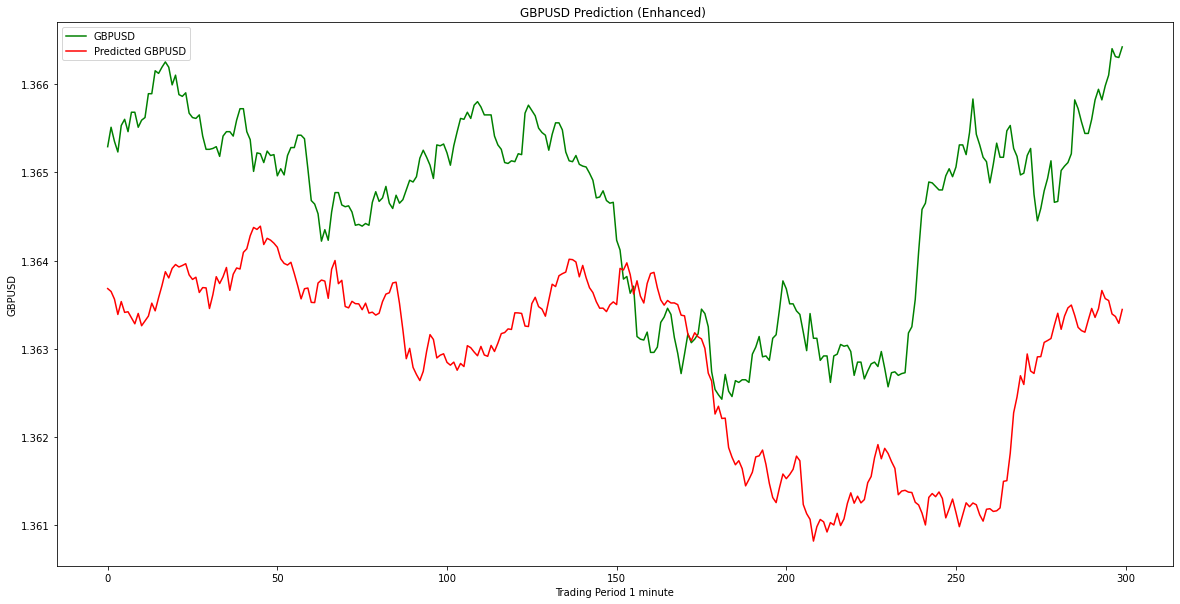

In [23]:
plt.figure(figsize=(20,10))
plt.plot(gbp_testdata[5000:5300], color = 'green', label = 'GBPUSD')
plt.plot(b[5000:5300, 33:34], color = 'red', label = 'Predicted GBPUSD')
plt.title('GBPUSD Prediction (Enhanced) ')
plt.xlabel('Trading Period 1 minute')
plt.ylabel('GBPUSD')
plt.legend()
plt.show()

## AUD MODEL

In [24]:
aud = pd.read_csv(f'C:/Users/STELLA/Desktop/Data Science/DS106/AUDUSD_1min.csv')

In [25]:
del aud['DateTime']
aud['Open'] = (aud['BidOpen'] + aud['AskOpen'])/2
aud['Close'] = (aud['BidClose'] + aud['AskClose'])/2
aud['High'] = (aud['BidHigh'] + aud['AskHigh'])/2
aud['Low'] = (aud['BidLow'] + aud['AskLow'])/2


In [26]:
aud = aud.drop({'Unnamed: 0','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose'}, axis=1)

In [27]:
aud

,Open,Close,High,Low
0,0.694205,0.694200,0.694205,0.694200
1,0.694200,0.694205,0.694320,0.694080
2,0.694205,0.694170,0.694370,0.693995
3,0.694170,0.694205,0.694260,0.694165
4,0.694205,0.694155,0.694250,0.694080
...,...,...,...,...
355819,0.759350,0.759370,0.759375,0.759345
355820,0.759370,0.759420,0.759445,0.759370
355821,0.759420,0.759435,0.759465,0.759410
355822,0.759435,0.759415,0.759465,0.759405


In [28]:
train_set = aud.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, len(train_set)-1):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [29]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [30]:
regressor.compile(optimizer = Adam(lr=1e-05), loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
11118/11118 [==============================] - 676s 61ms/step - loss: 0.0344
Epoch 2/30
11118/11118 [==============================] - 681s 61ms/step - loss: 0.0030
Epoch 3/30
11118/11118 [==============================] - 681s 61ms/step - loss: 0.0014
Epoch 4/30
11118/11118 [==============================] - 682s 61ms/step - loss: 9.8768e-04
Epoch 5/30
11118/11118 [==============================] - 681s 61ms/step - loss: 7.2293e-04
Epoch 6/30
11118/11118 [==============================] - 682s 61ms/step - loss: 5.4689e-04
Epoch 7/30
11118/11118 [==============================] - 682s 61ms/step - loss: 4.3082e-04
Epoch 8/30
11118/11118 [==============================] - 683s 61ms/step - loss: 3.5603e-04
Epoch 9/30
11118/11118 [==============================] - 683s 61ms/step - loss: 3.0823e-04
Epoch 10/30
11118/11118 [==============================] - 684s 62ms/step - loss: 2.7763e-04
Epoch 11/30
11118/11118 [==============================] - 690s 62ms/step - loss: 2.5865e-0

## Testing the model on new data

In [31]:
url = 'https://candledata.fxcorporate.com/'##This is the base url
periodicity='m1' ##periodicity, can be m1, H1, D1
url_suffix = '.csv.gz' ##Extension of the file name
symbol = 'AUDUSD' ##symbol we want to get tick data for
##Available Currencies 
##AUDCAD,AUDCHF,AUDJPY, AUDNZD,CADCHF,EURAUD,EURCHF,EURGBP
##EURJPY,EURUSD,GBPCHF,GBPJPY,GBPNZD,GBPUSD,GBPCHF,GBPJPY
##GBPNZD,NZDCAD,NZDCHF.NZDJPY,NZDUSD,USDCAD,USDCHF,USDJPY


##The candle files are stored in compressed csv.  The storage structure comes as {periodicity}/{symbol}/{year}/{week_of_year}.csv.gz
##The first week of the year will be 1.csv.gz where the 
##last week might be 52 or 53.  That will depend on the year.
##Once we have the week of the year we will be able to pull the correct file with the data that is needed.
start_dt =  dt.date(2021,1,15)##random start date
end_dt = dt.date(2021,2,15)##random end date


start_wk = start_dt.isocalendar()[1]##find the week of the year for the start  
end_wk = end_dt.isocalendar()[1] ##find the week of the year for the end 
year = str(start_dt.isocalendar()[0]) ##pull out the year of the start

###The URL is a combination of the currency, periodicity,  year, and week of the year.
###Example URL https://candledata.fxcorporate.com/m1/EURUSD/2017/29.csv.gz
###The example URL should be the first URL of this example
data=pd.DataFrame()
##This will loop through the weeks needed, create the correct URL and print out the lenght of the file.
for i in range(start_wk, end_wk ):
    url_data = url + periodicity + '/' + symbol + '/' + year + '/' + str(i) + url_suffix
    print(url_data)
    tempdata = pd.read_csv(url_data, compression='gzip')
    data =pd.concat([data, tempdata])

print(data)


https://candledata.fxcorporate.com/m1/AUDUSD/2021/2.csv.gz
https://candledata.fxcorporate.com/m1/AUDUSD/2021/3.csv.gz
https://candledata.fxcorporate.com/m1/AUDUSD/2021/4.csv.gz
https://candledata.fxcorporate.com/m1/AUDUSD/2021/5.csv.gz
https://candledata.fxcorporate.com/m1/AUDUSD/2021/6.csv.gz
                     DateTime  BidOpen  BidHigh   BidLow  BidClose  AskOpen  \
0     01/10/2021 22:01:00.000  0.77522  0.77522  0.77522   0.77522  0.77598   
1     01/10/2021 22:02:00.000  0.77522  0.77529  0.77522   0.77522  0.77581   
2     01/10/2021 22:03:00.000  0.77522  0.77544  0.77522   0.77522  0.77581   
3     01/10/2021 22:04:00.000  0.77522  0.77546  0.77522   0.77546  0.77581   
4     01/10/2021 22:05:00.000  0.77546  0.77548  0.77522   0.77538  0.77581   
...                       ...      ...      ...      ...       ...      ...   
7156  02/12/2021 21:54:00.000  0.77613  0.77616  0.77608   0.77610  0.77616   
7157  02/12/2021 21:55:00.000  0.77610  0.77610  0.77592   0.77597  0.776

In [32]:
aud_test = data
aud_test.to_csv(f'C:/Users/STELLA/Desktop/Data Science/DS106/AUDUSD_test.csv')

In [33]:
del aud_test['DateTime']
aud_test['Open'] = (aud_test['BidOpen'] + aud_test['AskOpen'])/2
aud_test['Close'] = (aud_test['BidClose'] + aud_test['AskClose'])/2
aud_test['High'] = (aud_test['BidHigh'] + aud_test['AskHigh'])/2
aud_test['Low'] = (aud_test['BidLow'] + aud_test['AskLow'])/2

In [35]:
aud_testdata = aud_test.iloc[:, 1:2].values
dataset_total = pd.concat((aud['Open'], aud_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(aud_test) - 60:].values


In [36]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(aud_testdata)-1):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [38]:
predicted_price= regressor.predict(X_test)


In [39]:
c = predicted_price.reshape(predicted_price.shape[0], 60)
c.shape

(35814, 60)

In [40]:

aud_predict = sc.inverse_transform(c)
aud_predict

array([[0.7578506 , 0.75845265, 0.7588593 , ..., 0.7584721 , 0.75848943,
        0.7584774 ],
       [0.7578506 , 0.75838673, 0.7587511 , ..., 0.7584893 , 0.7584773 ,
        0.7706497 ],
       [0.75778055, 0.758272  , 0.7587534 , ..., 0.75847715, 0.77064955,
        0.7723666 ],
       ...,
       [0.77224696, 0.77291656, 0.7737096 , ..., 0.7740916 , 0.7741495 ,
        0.77416986],
       [0.7721515 , 0.77290213, 0.7737267 , ..., 0.77414954, 0.7741699 ,
        0.77414167],
       [0.77214247, 0.7729276 , 0.77368927, ..., 0.77417004, 0.7741417 ,
        0.77412766]], dtype=float32)

In [41]:
aud_testdata.shape

(35875, 1)

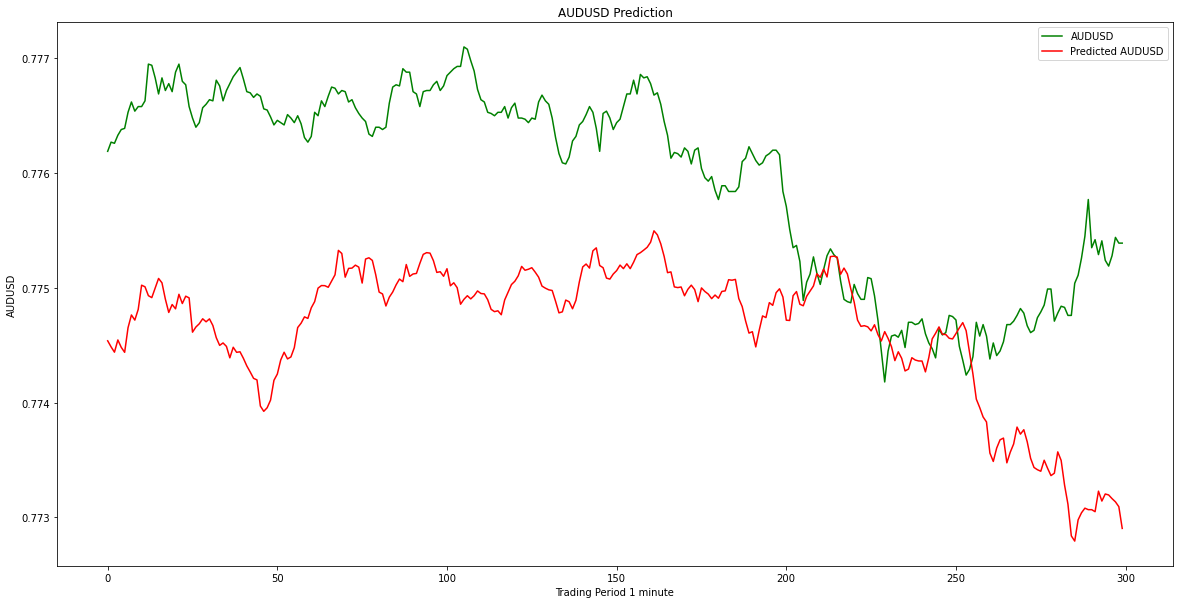

In [58]:
plt.figure(figsize=(20,10))
plt.plot(aud_testdata[5000:5300], color = 'green', label = 'AUDUSD')
plt.plot(aud_predict[5000:5300, 5:6], color = 'red', label = 'Predicted AUDUSD')
plt.title('AUDUSD Prediction')
plt.xlabel('Trading Period 1 minute')
plt.ylabel('AUDUSD')
plt.legend()
plt.show()

In [68]:
import os
# serialize model to JSON
model_json = regressor.to_json()
with open("audfwdsteplstm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
regressor.save_weights("audfwdsteplstm.h5")
print("Saved model to disk")

Saved model to disk
